In [1]:
import pymongo
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import seaborn as sns

In [54]:
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

In [55]:
db = client.testdb
tripadvisor = db.tripadvisor
yelp = db.yelp

In [106]:
# grab from mongo, sort by date, rename index to 'order' of appearance
df = pd.DataFrame(list(yelp.find()))
df = df.drop('_id', 1)
df = df.sort_values('date').reset_index()
df.columns = ['order' if x=='index' else x for x in df.columns]
df['day_of_week'] = df['date'].dt.weekday_name
df.head(10)

,order,city,date,id,rating,state,text,username,day_of_week
0,1551,Fairfax,2006-12-05,F41LRfdyzj4yagcDVsIS7g,4,VA,"I guess the ""Tavern"" in the name refers to the...",Gayle G.,Tuesday
1,1796,Washington,2006-12-18,QNJmkKw9hxN74IDCNLMEkg,5,DC,If you think this restaurant serving an Asian ...,Lydia P.,Monday
2,2057,Toronto,2007-01-09,FqptloYidzdvoratrazZ0w,3,Canada,An interesting experience but nothing spectacu...,Hratch P.,Tuesday
3,1797,Arlington,2007-04-23,aSvpHZYUXAdCMKbnF4iyKg,5,VA,The only restaurant in DC I give a 5-star. I h...,Haesung H.,Monday
4,1826,Alexandria,2007-05-21,UxpWvr2L7mzn8hY0iQDAoA,5,VA,I loved this restaurant. The interior is beau...,Beth F.,Monday
5,1992,Washington,2007-05-25,Qoq4XIHKdUVjDi1av8jnaA,5,DC,I had the most wonderful dinner here with my g...,RonAnderson ..,Friday
6,1810,Rockville,2007-06-01,pXNfAxsQHgf5TaY-F6wflA,4,MD,I had lunch at Blue Duck Tavern today and was ...,Betsy T.,Friday
7,1823,Sterling,2007-06-12,n-xTB-LQ8U6aN8Ix0Ei8Iw,5,VA,"Food -- One of their ""claims to fame"" is that ...",Sandra K.,Tuesday
8,1811,San Francisco,2007-06-26,YYYalIsJ_NkGCd2hbJ6YgQ,4,CA,We have been visiting DC and were looking for ...,Carla B.,Tuesday
9,1857,San Francisco,2007-07-01,45NswQQmgdZIFYvZ_pql8A,5,CA,I went here with a group - there were 6 of us ...,Bahareh W.,Sunday


In [5]:
days_grouped = df.groupby(['rating', 'day_of_week']).count()
days_grouped = days_grouped.reset_index()
days_grouped

,rating,day_of_week,order,city,date,id,state,text,username
0,1,Friday,4,4,4,4,4,4,4
1,1,Monday,15,15,15,15,15,15,15
2,1,Saturday,8,8,8,8,8,8,8
3,1,Sunday,13,13,13,13,13,13,13
4,1,Thursday,6,6,6,6,6,6,6
5,1,Tuesday,9,9,9,9,9,9,9
6,1,Wednesday,7,7,7,7,7,7,7
7,2,Friday,12,12,12,12,12,12,12
8,2,Monday,20,20,20,20,20,20,20
9,2,Saturday,20,20,20,20,20,20,20


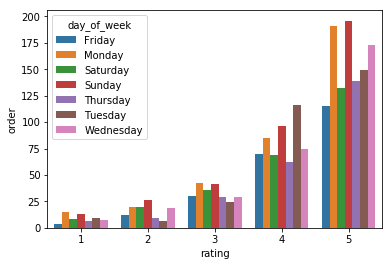

In [6]:
sns.barplot(data = days_grouped, x='rating', y='order', hue='day_of_week')

In [7]:
# group by date with monthly average
df1 = df.groupby(pd.Grouper(key='date', freq='1M')).mean()
df1 = df1[['rating']]
df1.head()

,rating
date,
2006-12-31,4.5
2007-01-31,3.0
2007-02-28,NaN
2007-03-31,NaN
2007-04-30,5.0


In [8]:
# add missing values
df1 = (df1
       .resample('M')
       .mean()
       .interpolate('linear'))
df1.head()

,rating
date,
2006-12-31,4.500000
2007-01-31,3.000000
2007-02-28,3.666667
2007-03-31,4.333333
2007-04-30,5.000000


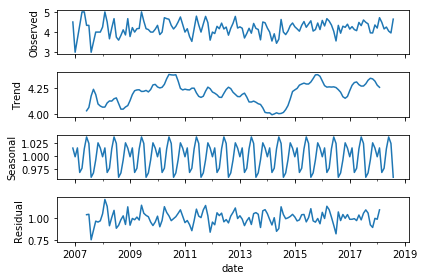

In [9]:
# decompose data
series = df1
# series = df[['date','rating']].set_index('date')
result = seasonal_decompose(series, model='multiplicative', freq=12)
result.plot()
pyplot.show()

In [10]:
df1 = df1.reset_index()
df1.head()

,date,rating
0,2006-12-31,4.500000
1,2007-01-31,3.000000
2,2007-02-28,3.666667
3,2007-03-31,4.333333
4,2007-04-30,5.000000


In [11]:
# decompose from 2011
series = df1.loc[df1['date'] > '2011-01-01'].set_index('date')
# series = df[['date','rating']].set_index('date')
result = seasonal_decompose(series, model='multiplicative', freq=12)
# result.plot()
# pyplot.show()


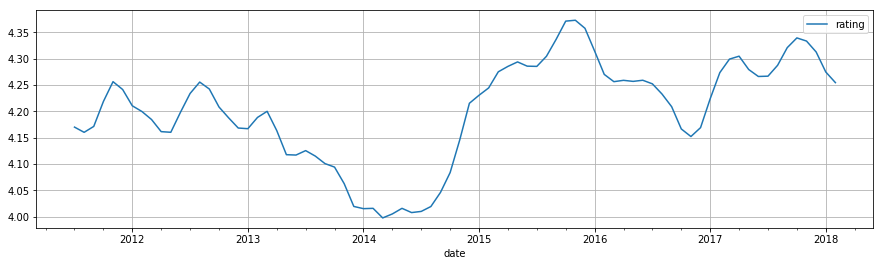

In [12]:
result.trend.plot(figsize=(15,4), grid=True)

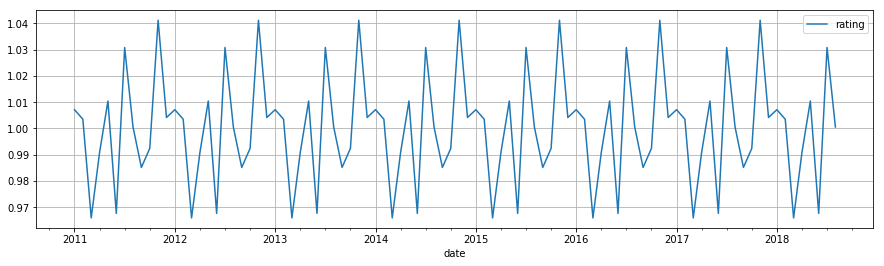

In [13]:
result.seasonal.plot(figsize=(15,4), grid=True)

In [14]:
result.seasonal.loc[result.seasonal['rating'].idxmax()]

rating    1.041146
Name: 2011-11-30 00:00:00, dtype: float64

In [15]:
result.seasonal.loc[result.seasonal['rating'].idxmin()]

rating    0.966001
Name: 2011-03-31 00:00:00, dtype: float64

In [16]:
# result.seasonal = result.seasonal.reset_index()
result.seasonal.head()

,rating
date,
2011-01-31,1.007148
2011-02-28,1.003516
2011-03-31,0.966001
2011-04-30,0.990886
2011-05-31,1.010445


In [17]:
result.seasonal.loc[result.seasonal['rating'] > (result.seasonal.max().rating - 0.02)]

,rating
date,
2011-07-31,1.030791
2011-11-30,1.041146
2012-07-31,1.030791
2012-11-30,1.041146
2013-07-31,1.030791
2013-11-30,1.041146
2014-07-31,1.030791
2014-11-30,1.041146
2015-07-31,1.030791


In [18]:
result.seasonal.loc[result.seasonal['rating'] < (result.seasonal.min().rating + 0.02) ]

,rating
date,
2011-03-31,0.966001
2011-06-30,0.967719
2011-09-30,0.985188
2012-03-31,0.966001
2012-06-30,0.967719
2012-09-30,0.985188
2013-03-31,0.966001
2013-06-30,0.967719
2013-09-30,0.985188


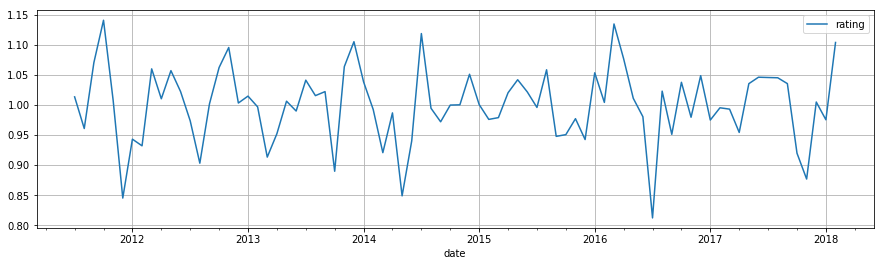

In [19]:
result.resid.plot(figsize=(15,4), grid=True)

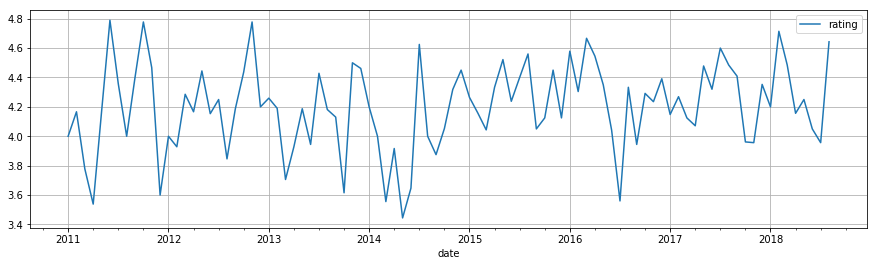

In [20]:
result.observed.plot(figsize=(15,4), grid=True)

In [21]:
df_2017 = df[df['date'].dt.year == 2017]

In [24]:
df_2017.head()

,order,city,date,id,rating,state,text,username,day_of_week
1579,629,Bloomfield,2017-01-01,6HpQAWZu57COm_yhUFFyAA,5,NJ,We had never been to the Blue Duck Tavern befo...,Lauren F.,Sunday
1580,446,Springfield,2017-01-01,6V-ruOSfefQFy_pgunQv3Q,1,VA,I've eaten at several Michelin star restaurant...,A A.,Sunday
1581,278,New York,2017-01-01,L1oLGwQzzEKcmfj2LYH9sw,2,NY,"2 Michelin stars in 2016, but brunch is remark...",George C.,Sunday
1582,860,Arlington,2017-01-01,Fun0ANhdAI2pzyZF8YYIoA,5,VA,Connor provided superb service and we thorough...,John T.,Sunday
1583,897,Norfolk,2017-01-03,gH4nMrK51E711N1AobceIA,5,VA,Definitely did not disappoint as the first Mic...,Andrew M.,Tuesday


In [25]:
df2 = df_2017.groupby(pd.Grouper(key='date', freq='1M')).mean()
df2 = df2[['rating']]

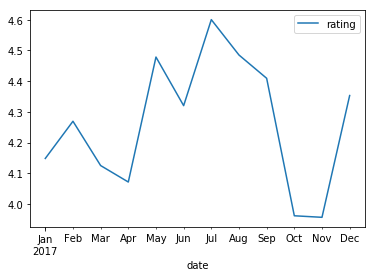

In [26]:
df2.plot()

In [27]:
import nltk
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [28]:
comment_words = ' '
stopwords = set(STOPWORDS)
stopwords.add('blue')
stopwords.add('duck')
stopwords.add('tavern')
stopwords.add('restaurant')
stopwords.add('food')

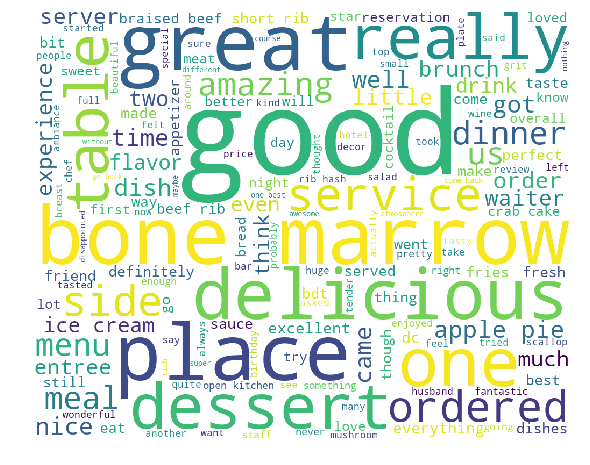

In [29]:
for ind, row in df.iterrows():
    tokens = row.text.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
         
    for words in tokens:
        comment_words += (words + ' ')
        
wordcloud = WordCloud(width = 1000, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 13).generate(comment_words)

plt.figure(figsize = (8, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()
    

In [31]:
df['state'].value_counts()

 DC                520
 VA                408
 CA                235
 MD                208
 NY                158
 FL                 49
 MA                 45
 NJ                 42
 TX                 41
 PA                 39
 IL                 37
 WA                 30
 Washingto          24
 GA                 22
 NC                 17
 NV                 16
 MI                 14
 CO                 13
 CT                 12
 HI                 11
 AZ                  9
 TN                  7
 LA                  7
 Queen               7
 SC                  6
 Canada              6
 IN                  5
 MN                  5
 OR                  5
 KY                  4
                  ... 
 NM                  2
 Japan               2
 New Yor             2
 AK                  2
 Los Angele          2
 Singapore           2
 Brazil              2
 United Kingdom      2
 UT                  2
 Australia           2
 AL                  2
 Belgium             2
 DE        

In [80]:
df_usa = df[df['state'].apply(lambda x: len(x) > 2)]

In [82]:
df_usa.head(20)

,order,city,date,id,rating,state,text,username,day_of_week
2,2057,Toronto,2007-01-09,FqptloYidzdvoratrazZ0w,3,Canada,An interesting experience but nothing spectacu...,Hratch P.,Tuesday
55,1973,Frankfurt,2008-10-28,xk3QZyzJbtWKWt0xHwGnLA,4,Germany,"Maybe it's the economy, maybe all the politico...",Dian C.,Tuesday
87,1773,Lakeview,2009-03-05,sSNsI1ccaVOtnh56FrrlbQ,3,Chicag,My husband and I dined here before attending a...,Kendall A.,Thursday
124,1710,Astoria,2009-09-09,cCF9ezV7reoY9BcryvdWRw,4,Queen,"A lovely dinner experience with, if you can ge...",Katey G.,Wednesday
182,1543,Toronto,2010-05-01,JAvp4GapyOn0J7_4niyMpQ,5,Canada,The Blue Duck Tavern is truly a unique dining ...,John I.,Saturday
317,1430,Foggy Bottom,2011-04-06,bU-WGo8RiQzdUEwBJbuS1A,4,Washingto,"A delightful dinner.For starters, the bone mar...",Ryan R.,Wednesday
350,2006,Geneva,2011-06-14,ZpKl1Jr4EPgObHtu054rFQ,5,Switzerland,One of my favourite places in DC. Stellar serv...,Emma H.,Tuesday
362,1385,Madrid,2011-07-07,GosnDLRWcDjlkZt-MmAnjw,5,Spain,Blue Duck Tavern (BDT) does not disappoint--I ...,Katherine H.,Thursday
394,1886,Frankfurt,2011-10-07,QGjU9JGGu2Cdt1qzp5tPEQ,4,Germany,If you appreciate a good charcuterie and chees...,Karin P.,Friday
484,1258,Singapore,2012-05-12,bswktkxTqTFdhg8uvcuWWw,5,Singapore,On our recent visit for the 3C's in DC (Crabca...,Ida C.,Saturday


In [36]:
df_usa['state'] = df_usa['state'][1:]

In [60]:
import plotly.plotly as py
import plotly.figure_factory as ff
import numpy as np
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [61]:
colors = ["#fafa6e","#9cdf7c","#4abd8c","#00968e","#106e7c","#2a4858"]

In [62]:
pairs = df_usa[df_usa['rating'].apply(lambda r: r <= 2)]['state'].value_counts()

In [63]:
states = pairs.keys().tolist()
values = pairs.values.astype(int).tolist()
endpts = list(np.linspace(1, 12, len(colors) - 1))

In [121]:
fig = ff.create_choropleth(
    fips = states,
    values=values,
    binning_endpoints=endpts,
    colorscale=colors,
    show_state_data=True,
    show_hover=True, centroid_marker={'opacity': 0}
)
py.iplot(fig, filename='choropleth_full_usa')

/Users/sonik/anaconda3/envs/pythondata/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




ValueError: invalid literal for int() with base 10: ' VA'

In [78]:
data = [dict(
    type = "choropleth",
    colorscale = [[0, 'green'], [0.5, 'yellow'], [1.0, 'red']],
    locations = states,
    z = values,
    locationmode = 'USA-states',
    text = states,
    marker = {'line': {'color': 'rgb(255,255,255)', 'width': 2}},
    colorbar = {'title': 'rating 1-2'}
)]

layout = dict(title = 'rating 1-2', geo = dict(scope="usa", showlakes = True,lakecolor = 'rgb(255, 100, 200)'))



In [79]:
fig = go.Figure(data = data, layout = layout)
iplot(fig, filename='d3-cloropleth-map')

In [84]:
codes = pd.read_csv('plotly_countries_and_codes.csv')

In [87]:
print(codes.head())
print(df.head())

          COUNTRY  GDP (BILLIONS) CODE
0     Afghanistan           21.71  AFG
1         Albania           13.40  ALB
2         Algeria          227.80  DZA
3  American Samoa            0.75  ASM
4         Andorra            4.80  AND
   order        city       date                      id  rating   state  \
0   1551     Fairfax 2006-12-05  F41LRfdyzj4yagcDVsIS7g       4      VA   
1   1796  Washington 2006-12-18  QNJmkKw9hxN74IDCNLMEkg       5      DC   
2   2057     Toronto 2007-01-09  FqptloYidzdvoratrazZ0w       3  Canada   
3   1797   Arlington 2007-04-23  aSvpHZYUXAdCMKbnF4iyKg       5      VA   
4   1826  Alexandria 2007-05-21  UxpWvr2L7mzn8hY0iQDAoA       5      VA   

                                                text    username day_of_week  
0  I guess the "Tavern" in the name refers to the...    Gayle G.     Tuesday  
1  If you think this restaurant serving an Asian ...    Lydia P.      Monday  
2  An interesting experience but nothing spectacu...   Hratch P.     Tuesday  

In [92]:
codes_dict = {}
for i, row in codes.iterrows():
    codes_dict[row.COUNTRY] = row.CODE

In [107]:
df['code'] = ''

In [108]:
for i, row in df.iterrows():
    if row.state in codes_dict:
#         df.set_value(i, 'code', codes_dict[row.state])
        df.at[i, 'code'] = codes_dict[row.state]
    else:
        df.at[i, 'code'] = 'nothing'

In [109]:
df.head()

,order,city,date,id,rating,state,text,username,day_of_week,code
0,1551,Fairfax,2006-12-05,F41LRfdyzj4yagcDVsIS7g,4,VA,"I guess the ""Tavern"" in the name refers to the...",Gayle G.,Tuesday,nothing
1,1796,Washington,2006-12-18,QNJmkKw9hxN74IDCNLMEkg,5,DC,If you think this restaurant serving an Asian ...,Lydia P.,Monday,nothing
2,2057,Toronto,2007-01-09,FqptloYidzdvoratrazZ0w,3,Canada,An interesting experience but nothing spectacu...,Hratch P.,Tuesday,CAN
3,1797,Arlington,2007-04-23,aSvpHZYUXAdCMKbnF4iyKg,5,VA,The only restaurant in DC I give a 5-star. I h...,Haesung H.,Monday,nothing
4,1826,Alexandria,2007-05-21,UxpWvr2L7mzn8hY0iQDAoA,5,VA,I loved this restaurant. The interior is beau...,Beth F.,Monday,nothing


In [115]:
countries = df[df['code'].apply(lambda x: x != 'nothing')]['code'].value_counts()

In [117]:
cc = countries.keys().tolist()
vals = countries.values.astype(int).tolist()

[6, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1]

In [114]:
countries.head()

,order,city,date,id,rating,state,text,username,day_of_week,code
2,2057,Toronto,2007-01-09,FqptloYidzdvoratrazZ0w,3,Canada,An interesting experience but nothing spectacu...,Hratch P.,Tuesday,CAN
55,1973,Frankfurt,2008-10-28,xk3QZyzJbtWKWt0xHwGnLA,4,Germany,"Maybe it's the economy, maybe all the politico...",Dian C.,Tuesday,DEU
182,1543,Toronto,2010-05-01,JAvp4GapyOn0J7_4niyMpQ,5,Canada,The Blue Duck Tavern is truly a unique dining ...,John I.,Saturday,CAN
350,2006,Geneva,2011-06-14,ZpKl1Jr4EPgObHtu054rFQ,5,Switzerland,One of my favourite places in DC. Stellar serv...,Emma H.,Tuesday,CHE
362,1385,Madrid,2011-07-07,GosnDLRWcDjlkZt-MmAnjw,5,Spain,Blue Duck Tavern (BDT) does not disappoint--I ...,Katherine H.,Thursday,ESP


In [134]:
data = [dict(
    type = "choropleth",
    colorscale = [[0, 'green'], [0.5, 'yellow'], [1.0, 'red']],
    locations = cc,
    z = vals,
    locationmode = 'country names',
    text = cc,
    marker = {'line': {'color': 'rgb(255,255,255)', 'width': 2}},
    colorbar = {'title': 'countries'}
)]

layout = dict(title = 'rating 1-2', geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'equirectangular')))

In [135]:
fig = go.Figure(data = data, layout = layout)
iplot(fig, filename='d3-cloropleth-map')